In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score , confusion_matrix, accuracy_score , classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

import pickle 
import os 

import cv2 
%matplotlib inline

c:\Users\Hp\miniconda3\envs\gpu_39\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 200

In [4]:
def load_data(data_dir):
    X = []
    y = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img_name in os.listdir(path):
           
            img_path = os.path.join(path, img_name)
            img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size))
            X.append(resized_arr)
            y.append(class_num)
            
    return np.array(X), np.array(y)

In [5]:
X_train, y_train = load_data('chest_xray/train')
X_test, y_test = load_data('chest_xray/test')
X_val, y_val = load_data('chest_xray/val')

In [6]:
y_train_series = pd.Series(y_train)
y_train_series.unique()


array([0, 1])

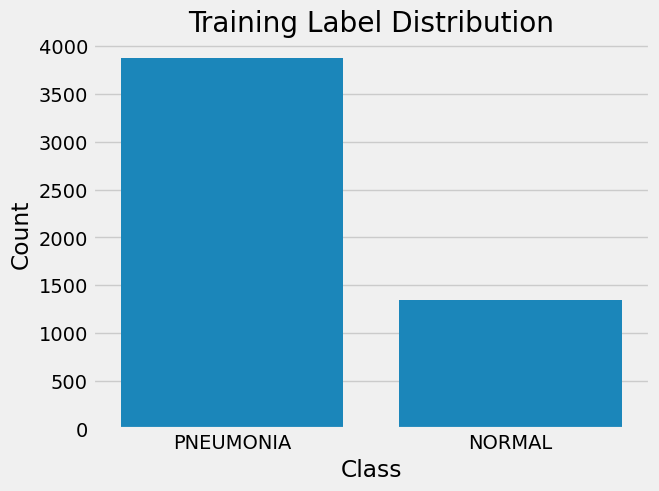

In [7]:

sns.countplot(x=y_train_series.map(lambda x: labels[x]))


plt.title("Training Label Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [8]:
# Class Balance Check
pneumonia = np.sum(y_train == 0)
normal = np.sum(y_train == 1)

print("Pneumonia:", pneumonia)
print("Normal:", normal)
print("Difference (Pneumonia - Normal):", pneumonia - normal)


Pneumonia: 3875
Normal: 1341
Difference (Pneumonia - Normal): 2534


Label: PNEUMONIA


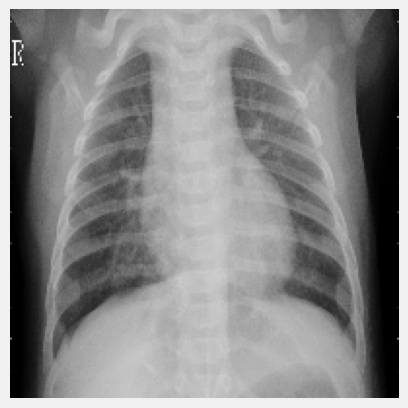

In [9]:
plt.imshow(X_train[1].reshape(img_size, img_size), cmap='gray')
plt.axis('off')
print("Label:", labels[y_train[1]])

Label: PNEUMONIA


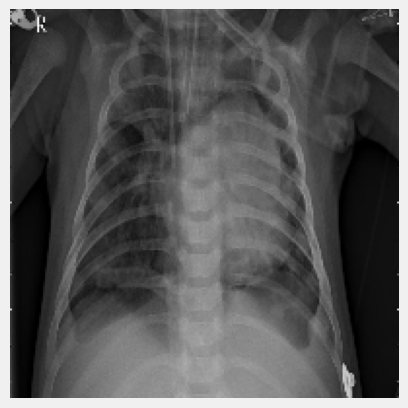

In [10]:
plt.imshow(X_test[1].reshape(img_size, img_size), cmap='gray')
plt.axis('off')
print("Label:", labels[y_test[1]])

Label: PNEUMONIA


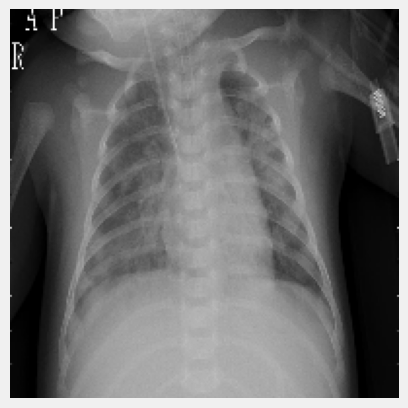

In [11]:
plt.imshow(X_val[1].reshape(img_size, img_size), cmap='gray')
plt.axis('off')
print("Label:", labels[y_val[1]])

In [12]:
# Reshape and Normalize
X_train = X_train.reshape(-1, img_size, img_size, 1) / 255.0
X_test = X_test.reshape(-1, img_size, img_size, 1) / 255.0
X_val = X_val.reshape(-1, img_size, img_size, 1) / 255.0

In [13]:
# Augmentation for Training Data
datagen = ImageDataGenerator(
    rotation_range=90,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

datagen.fit(X_train)


In [ ]:
# model 
model = Sequential()

# Layer 1
model.add(Conv2D(32, (3, 3), input_shape=X_train.shape[1:], padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=-1))

# Layer 2
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=-1))

# Layer 3
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization(axis=-1))

# Flatten and Dense
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))  # Binary classification

# Compile
adam = Adam(learning_rate=0.0001)

early_stop = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

In [15]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10, 
    validation_data=(X_val, y_val),
    callbacks=[early_stop]
)

Epoch 1/10
163/163 [==============================] - 92s 514ms/step - loss: 0.3974 - accuracy: 0.8416 - val_loss: 7.3410 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 83s 506ms/step - loss: 0.2658 - accuracy: 0.8917 - val_loss: 8.2811 - val_accuracy: 0.5000
Epoch 3/10
163/163 [==============================] - 89s 548ms/step - loss: 0.2542 - accuracy: 0.8953 - val_loss: 4.4364 - val_accuracy: 0.5000
Epoch 4/10
163/163 [==============================] - 86s 525ms/step - loss: 0.2430 - accuracy: 0.9003 - val_loss: 2.0944 - val_accuracy: 0.5625
Epoch 5/10
163/163 [==============================] - 84s 516ms/step - loss: 0.2309 - accuracy: 0.9039 - val_loss: 0.7894 - val_accuracy: 0.7500
Epoch 6/10
163/163 [==============================] - 83s 509ms/step - loss: 0.2270 - accuracy: 0.9080 - val_loss: 0.4461 - val_accuracy: 0.8125
Epoch 7/10
163/163 [==============================] - 83s 508ms/step - loss: 0.2124 - accuracy: 0.9160 - val_loss: 0.4974 - val_ac

In [16]:
# training accuracy check 
final_train_accuracy = history.history['accuracy'][-1]
print("Training Accuracy:", final_train_accuracy * 100, "%")

Training Accuracy: 92.12039709091187 %


In [21]:
# testing accuracy check 
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc * 100, "%")

20/20 [==============================] - 3s 135ms/step - loss: 0.2618 - accuracy: 0.8798
Test Accuracy: 87.9807710647583 %


In [22]:
y_pred_probs = model.predict(X_test)
y_pred_labels = (y_pred_probs > 0.5).astype(int).reshape(-1)

20/20 [==============================] - 2s 129ms/step


In [26]:
print(classification_report(y_test, y_pred_labels, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.94      0.86      0.90       390
   Normal (Class 1)       0.80      0.91      0.85       234

           accuracy                           0.88       624
          macro avg       0.87      0.89      0.87       624
       weighted avg       0.89      0.88      0.88       624



In [30]:
model.save("Pneumonia_Classifier_Model.h5")